In [1]:
!pip install xgboost
!pip install sklearn
!pip install hyperopt
!pip install preprocess_features
!pip install -U seaborn

ERROR: Could not find a version that satisfies the requirement preprocess_features (from versions: none)
ERROR: No matching distribution found for preprocess_features


Requirement already up-to-date: seaborn in c:\users\18482\anaconda3\lib\site-packages (0.11.2)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import xgboost as xgb
from xgboost.sklearn import (XGBClassifier, XGBRegressor)

from sklearn.metrics import (r2_score,
                            mean_squared_error,
                            median_absolute_error,
                            roc_auc_score,
                            auc,
                            classification_report,
                            confusion_matrix,
                            roc_curve)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import (mutual_info_classif,
                                       mutual_info_regression)
from sklearn.preprocessing import (OneHotEncoder,
                                  StandardScaler,
                                  LabelEncoder,
                                  label_binarize)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import (KFold,
                                    train_test_split)

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [3]:
##from preprocess_features import *
##from visual_functions import *
##from hyperparameter_tuning import *

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
sns.set_style('whitegrid')

### Load Data

In [6]:
Test = pd.read_csv("Test_Dataset.csv")
Train = pd.read_csv("Training_Dataset.csv")

In [7]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ListingID             6298 non-null   int64  
 1   SellerCity            6298 non-null   object 
 2   SellerIsPriv          6298 non-null   bool   
 3   SellerListSrc         6296 non-null   object 
 4   SellerName            6298 non-null   object 
 5   SellerRating          6298 non-null   float64
 6   SellerRevCnt          6298 non-null   int64  
 7   SellerState           6298 non-null   object 
 8   SellerZip             6296 non-null   float64
 9   VehBodystyle          6298 non-null   object 
 10  VehCertified          6298 non-null   bool   
 11  VehColorExt           6225 non-null   object 
 12  VehColorInt           5570 non-null   object 
 13  VehDriveTrain         5897 non-null   object 
 14  VehEngine             5937 non-null   object 
 15  VehFeats             

In [8]:
Train=Train.set_index('ListingID')

In [9]:
Train.head()

SellerCity  SellerIsPriv               SellerListSrc  \
ListingID                                                           
3287             Warren         False    Inventory Command Center   
3920              Fargo         False  Cadillac Certified Program   
4777           Waukesha         False      Jeep Certified Program   
6242         Wentzville         False    Inventory Command Center   
7108       Fayetteville         False          HomeNet Automotive   

                                           SellerName  SellerRating  \
ListingID                                                             
3287                                     Prime Motorz           5.0   
3920                       Gateway Chevrolet Cadillac           4.8   
4777       Wilde Chrysler Jeep Dodge Ram &amp; Subaru           4.8   
6242                  Century Dodge Chrysler Jeep RAM           4.4   
7108               Superior Buick GMC of Fayetteville           3.7   

           SellerRevCnt SellerState  SellerZip VehBodystyle  VehCertified  \
ListingID                                                                   
3287                 32          MI    48091.0          SUV         False   
3920               1456          ND    58103.0          SUV          True   
4777               1405          WI    53186.0          SUV          True   
6242                 21          MO    63385.0          SUV         False   
7108                 74          AR    72703.0          SUV         False   

           ...   VehMake VehMileage        VehModel VehPriceLabel  \
ListingID  ...                                                      
3287       ...      Jeep    39319.0  Grand Cherokee    Fair Price   
3920       ...  Cadillac    30352.0             XT5     Good Deal   
4777       ...      Jeep    38957.0  Grand Cherokee     Good Deal   
6242       ...      Jeep    20404.0  Grand Cherokee     Good Deal   
7108       ...  Cadillac    19788.0             XT5     Good Deal   

                                              VehSellerNotes VehType  \
ListingID                                                              
3287                                                     NaN    Used   
3920       Come take a look at our great pre-owned invent...    Used   
4777       Backed by a rigorous 125-point inspection by f...    Used   
6242       Drop by to see us and you will quickly see how...    Used   
7108       Luxury, Exterior Parking Camera Rear, Front Du...    Used   

                  VehTransmission  VehYear   Vehicle_Trim  \
ListingID                                                   
3287            Automatic 8-Speed     2015  High Altitude   
3920                          NaN     2017            NaN   
4777       8-Speed Automatic w/OD     2015         Laredo   
6242                    Automatic     2018        Limited   
7108            8-Speed Automatic     2018         Luxury   

           Dealer_Listing_Price  
ListingID                        
3287                    30990.0  
3920                    34860.0  
4777                    23249.0  
6242                    31977.0  
7108                    33495.0  

[5 rows x 28 columns]

In [10]:
Train.columns = Train.columns.str.lower()

In [11]:
Train.columns

Index(['sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername',
       'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip',
       'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint',
       'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel',
       'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear',
       'vehicle_trim', 'dealer_listing_price'],
      dtype='object')

## Separate Dependent and Independent Variables

### Not necessary, but I want to split the dependent and independent variable apart to inspect the data

In [12]:
y = Train[['vehicle_trim', 'dealer_listing_price']]
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_trim          5893 non-null   object 
 1   dealer_listing_price  6246 non-null   float64
dtypes: float64(1), object(1)
memory usage: 147.6+ KB


In [13]:
y.isna().sum()

vehicle_trim            405
dealer_listing_price     52
dtype: int64

In [14]:
y.head()

vehicle_trim  dealer_listing_price
ListingID                                     
3287       High Altitude               30990.0
3920                 NaN               34860.0
4777              Laredo               23249.0
6242             Limited               31977.0
7108              Luxury               33495.0

In [15]:
x = Train.drop(y.columns, axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6298 entries, 3287 to 8620012
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sellercity       6298 non-null   object 
 1   sellerispriv     6298 non-null   bool   
 2   sellerlistsrc    6296 non-null   object 
 3   sellername       6298 non-null   object 
 4   sellerrating     6298 non-null   float64
 5   sellerrevcnt     6298 non-null   int64  
 6   sellerstate      6298 non-null   object 
 7   sellerzip        6296 non-null   float64
 8   vehbodystyle     6298 non-null   object 
 9   vehcertified     6298 non-null   bool   
 10  vehcolorext      6225 non-null   object 
 11  vehcolorint      5570 non-null   object 
 12  vehdrivetrain    5897 non-null   object 
 13  vehengine        5937 non-null   object 
 14  vehfeats         6023 non-null   object 
 15  vehfuel          6296 non-null   object 
 16  vehhistory       6097 non-null   object 
 17  vehlistd

In [16]:
x.isna().sum()

sellercity           0
sellerispriv         0
sellerlistsrc        2
sellername           0
sellerrating         0
sellerrevcnt         0
sellerstate          0
sellerzip            2
vehbodystyle         0
vehcertified         0
vehcolorext         73
vehcolorint        728
vehdrivetrain      401
vehengine          361
vehfeats           275
vehfuel              2
vehhistory         201
vehlistdays          2
vehmake              0
vehmileage           2
vehmodel             0
vehpricelabel      285
vehsellernotes     243
vehtype              0
vehtransmission    197
vehyear              0
dtype: int64

## Explore, Clean, Transform, And Engineer Features

In [17]:
y.head()

vehicle_trim  dealer_listing_price
ListingID                                     
3287       High Altitude               30990.0
3920                 NaN               34860.0
4777              Laredo               23249.0
6242             Limited               31977.0
7108              Luxury               33495.0

In [18]:
y['vehicle_trim'].value_counts()

Limited                             1912
Premium Luxury                       747
Laredo                               704
Luxury                               645
Overland                             381
Altitude                             325
Summit                               242
Trailhawk                            178
Base                                 159
Platinum                             131
High Altitude                         86
SRT                                   76
Luxury FWD                            53
FWD                                   49
Laredo E                              47
Premium Luxury FWD                    35
Trackhawk                             30
Sterling Edition                      26
Luxury AWD                            22
Platinum AWD                          13
Premium Luxury AWD                     9
75th Anniversary                       8
Limited 75th Anniversary Edition       5
Upland                                 3
SRT Night       

### We need to clean up the value counts dispersion, as SRT and SRT NIGHT could technically be an non-distinguishable feature that wouldn't fit the model we are trying to build. 
### Same goes for Limited and Limited X.

In [19]:
# Check which makes have "Luxury" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('luxury') == True, 'vehmake'].value_counts()

Cadillac    1511
Name: vehmake, dtype: int64

In [20]:
# Check which make have "Limited" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('limited') == True, 'vehmake'].value_counts()

Jeep    1920
Name: vehmake, dtype: int64

In [21]:
# Check which makes have "Laredo" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('laredo') == True, 'vehmake'].value_counts()

Jeep    751
Name: vehmake, dtype: int64

In [22]:
# Check which makes have "FWD" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('fwd') == True, 'vehmake'].value_counts()

Cadillac    137
Name: vehmake, dtype: int64

In [23]:
# Check which makes have "AWD" in the trim
Train.loc[y['vehicle_trim'].str.lower().str.contains('awd') == True, 'vehmake'].value_counts()

Cadillac    44
Name: vehmake, dtype: int64

In [24]:
# Check what makes exist
Train['vehmake'].value_counts()

Jeep        4199
Cadillac    2099
Name: vehmake, dtype: int64

In [25]:
Train.groupby('vehmake')['vehicle_trim'].value_counts()

vehmake   vehicle_trim                    
Cadillac  Premium Luxury                       747
          Luxury                               645
          Base                                 159
          Platinum                             131
          Luxury FWD                            53
          FWD                                   49
          Premium Luxury FWD                    35
          Luxury AWD                            22
          Platinum AWD                          13
          Premium Luxury AWD                     9
Jeep      Limited                             1912
          Laredo                               704
          Overland                             381
          Altitude                             325
          Summit                               242
          Trailhawk                            178
          High Altitude                         86
          SRT                                   76
          Laredo E                     

### Clean up vehicle_makes

Looking at how these trims are distributed, we are going to clean this up a bit.  First, let's actually separate the data into 2 data set....JEEP and CADILLAC.

In [26]:
Cadillac = Train[Train['vehmake'] == 'Cadillac']
Cadillac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099 entries, 3920 to 8617378
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            2099 non-null   object 
 1   sellerispriv          2099 non-null   bool   
 2   sellerlistsrc         2099 non-null   object 
 3   sellername            2099 non-null   object 
 4   sellerrating          2099 non-null   float64
 5   sellerrevcnt          2099 non-null   int64  
 6   sellerstate           2099 non-null   object 
 7   sellerzip             2099 non-null   float64
 8   vehbodystyle          2099 non-null   object 
 9   vehcertified          2099 non-null   bool   
 10  vehcolorext           2072 non-null   object 
 11  vehcolorint           1782 non-null   object 
 12  vehdrivetrain         1925 non-null   object 
 13  vehengine             1929 non-null   object 
 14  vehfeats              1863 non-null   object 
 15  vehfuel        

In [27]:
Jeep = Train[Train['vehmake'] == 'Jeep']
Jeep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4199 non-null   object 
 1   sellerispriv          4199 non-null   bool   
 2   sellerlistsrc         4197 non-null   object 
 3   sellername            4199 non-null   object 
 4   sellerrating          4199 non-null   float64
 5   sellerrevcnt          4199 non-null   int64  
 6   sellerstate           4199 non-null   object 
 7   sellerzip             4197 non-null   float64
 8   vehbodystyle          4199 non-null   object 
 9   vehcertified          4199 non-null   bool   
 10  vehcolorext           4153 non-null   object 
 11  vehcolorint           3788 non-null   object 
 12  vehdrivetrain         3972 non-null   object 
 13  vehengine             4008 non-null   object 
 14  vehfeats              4160 non-null   object 
 15  vehfuel        

### Cadillac

Now, we are going to clean the 'vehicle_trim' column by grouping similar trims together.

For Cadillac, we will keep:

    - Premium = Premium Luxury, Premium Luxury FWD, Premium Luxury AWD
    - Luxury = Luxury, Luxury FWD, Luxury AWD
    - Base = Base
    - Platinum = Platinum, Platinum AWD

The remaining trim "FWD" will be dropped, as it is merely 2% of observation and isn't actually a trim package, but rather a type of Drive Train.

In [28]:
Cadillac['vehicle_trim'].value_counts()

Premium Luxury        747
Luxury                645
Base                  159
Platinum              131
Luxury FWD             53
FWD                    49
Premium Luxury FWD     35
Luxury AWD             22
Platinum AWD           13
Premium Luxury AWD      9
Name: vehicle_trim, dtype: int64

In [29]:
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('premium') == True, 'vehicle_trim'] = 'premium'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('luxury') == True, 'vehicle_trim'] = 'luxury'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('base') == True, 'vehicle_trim'] = 'base'
Cadillac.loc[Cadillac['vehicle_trim'].str.lower().str.contains('platinum') == True, 'vehicle_trim'] = 'platinum'

In [30]:
Cadillac['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
FWD          49
Name: vehicle_trim, dtype: int64

In [31]:
Cadillac = Cadillac[Cadillac['vehicle_trim'] != 'FWD']
Cadillac['vehicle_trim'].value_counts()

premium     791
luxury      720
base        159
platinum    144
Name: vehicle_trim, dtype: int64

### Jeep

Just like we did for Cadillac, we will remove/consolidate the categories into the following buckets:

   - Limited = Limited, Limited 75th Anniversary Edition, Limited 75th Anniversary, Limited X
   - Laredo = Laredo, Laredo E
   - SRT = SRT, SRT Night
   
The rest of the trims, we will remove from consideration for this analysis

NOTE:  This "bucketing" choice of action is the highest risk within the analysis.  By ruling out the "75th Anniversary" as a deciding factor, we would need to augment the analysis all over again AT THIS POINT IN TIME. 


In [32]:
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('limited') == True, 'vehicle_trim'] = 'limited'
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('laredo') == True, 'vehicle_trim'] = 'laredo'
Jeep.loc[Jeep['vehicle_trim'].str.lower().str.contains('srt') == True, 'vehicle_trim'] = 'srt'

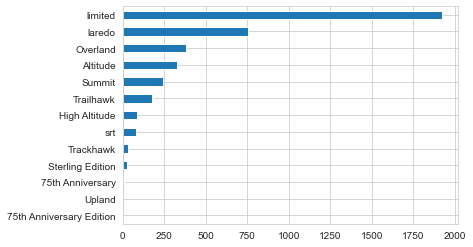

In [33]:
Jeep['vehicle_trim'].value_counts().sort_values().plot.barh();

In [34]:
keep_trims = ['limited','laredo','overland','altitude','summit','trailhawk','high altitude','srt','trackhawk']
Jeep = Jeep.loc[Jeep['vehicle_trim'].str.lower().isin(keep_trims),:] 
Jeep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992 entries, 3287 to 8620012
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            3992 non-null   object 
 1   sellerispriv          3992 non-null   bool   
 2   sellerlistsrc         3990 non-null   object 
 3   sellername            3992 non-null   object 
 4   sellerrating          3992 non-null   float64
 5   sellerrevcnt          3992 non-null   int64  
 6   sellerstate           3992 non-null   object 
 7   sellerzip             3990 non-null   float64
 8   vehbodystyle          3992 non-null   object 
 9   vehcertified          3992 non-null   bool   
 10  vehcolorext           3966 non-null   object 
 11  vehcolorint           3697 non-null   object 
 12  vehdrivetrain         3933 non-null   object 
 13  vehengine             3969 non-null   object 
 14  vehfeats              3976 non-null   object 
 15  vehfuel        

In [35]:
Jeep['vehicle_trim'].value_counts()

limited          1920
laredo            751
Overland          381
Altitude          325
Summit            242
Trailhawk         178
High Altitude      86
srt                79
Trackhawk          30
Name: vehicle_trim, dtype: int64

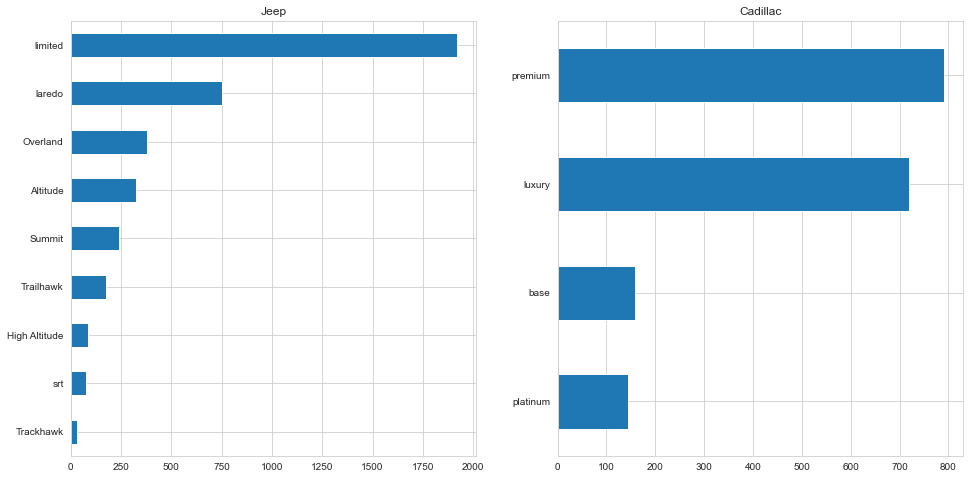

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
Jeep['vehicle_trim'].value_counts().sort_values().plot.barh(ax=axes[0])
axes[0].set_title('Jeep')
Cadillac['vehicle_trim'].value_counts().sort_values().plot.barh(ax=axes[1])
axes[1].set_title('Cadillac')
fig.savefig('trim_counts.png');

In [37]:
y['dealer_listing_price'].isna().sum()

52

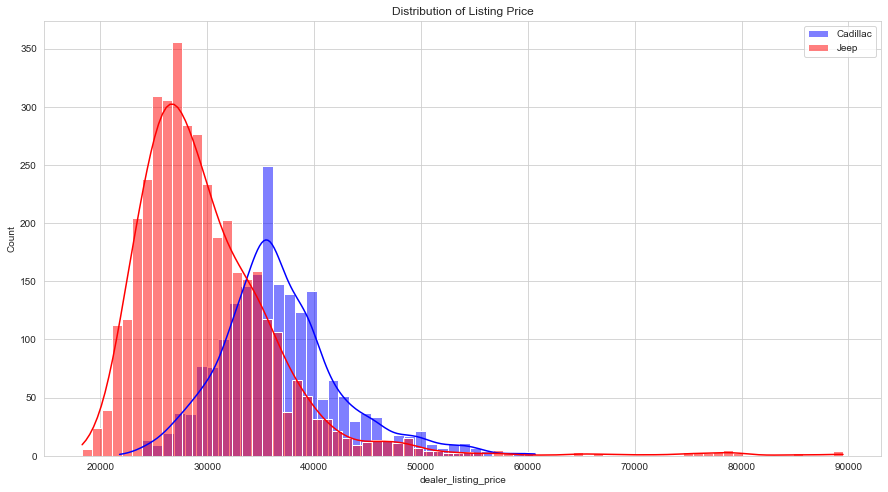

In [38]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(Cadillac['dealer_listing_price'], kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(Jeep['dealer_listing_price'], kde=True, color='red', ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Listing Price');

### Log Transform to display the look of normal distribution across both data sets

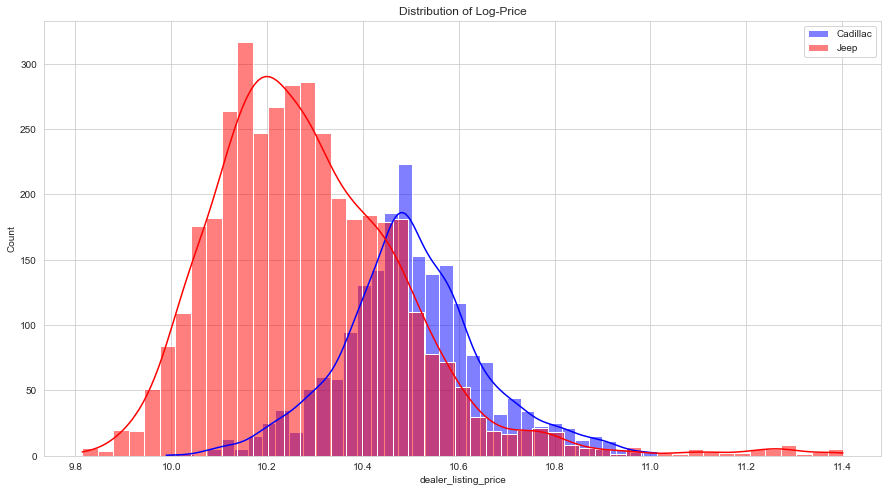

In [39]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(np.log(Cadillac['dealer_listing_price']), kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(np.log(Jeep['dealer_listing_price']), kde=True, color='red',ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Log-Price');

### This confirms that Log Transform DOES normalize the distribution of data.  As you can see, the data tails off at the end LESS than when using the raw data.

### Cadillac Data

Text(0.5, 0.98, 'Cadillac')

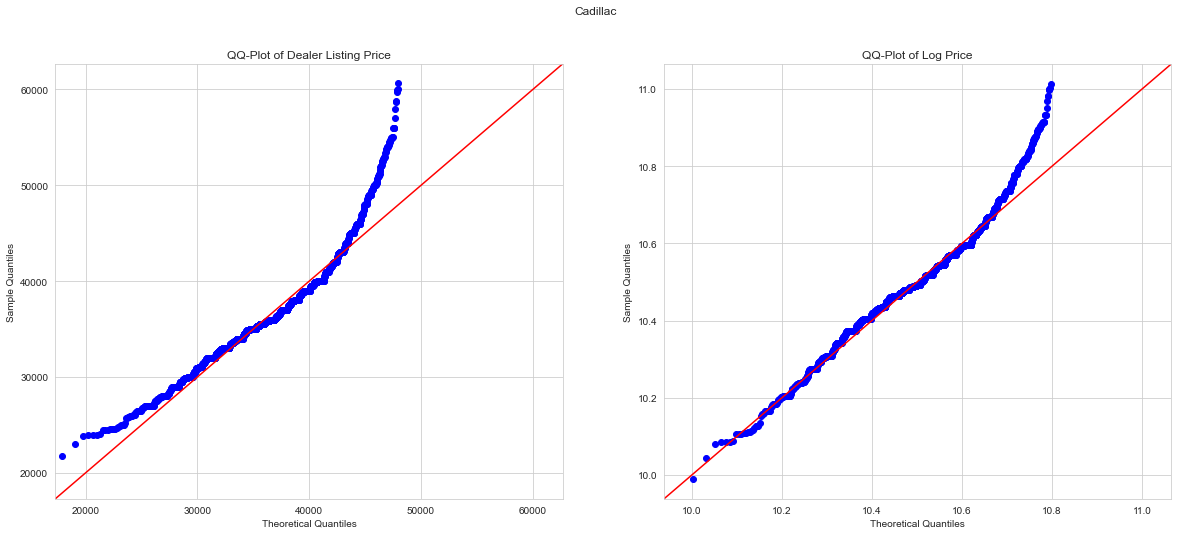

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sm.qqplot(Cadillac['dealer_listing_price'],
           loc=Cadillac['dealer_listing_price'].mean(),
           scale=Cadillac['dealer_listing_price'].std(),
           ax=axes[0], line='45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp=np.log(Cadillac['dealer_listing_price'])
sm.qqplot(temp,
         loc=temp.mean(),
         scale=temp.std(),
         ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Cadillac')

### Jeep Data

   ### Note:  Unlike Cadillac, the data is a little skewed, as data covers a wider range of pricing

Text(0.5, 0.98, 'Jeep')

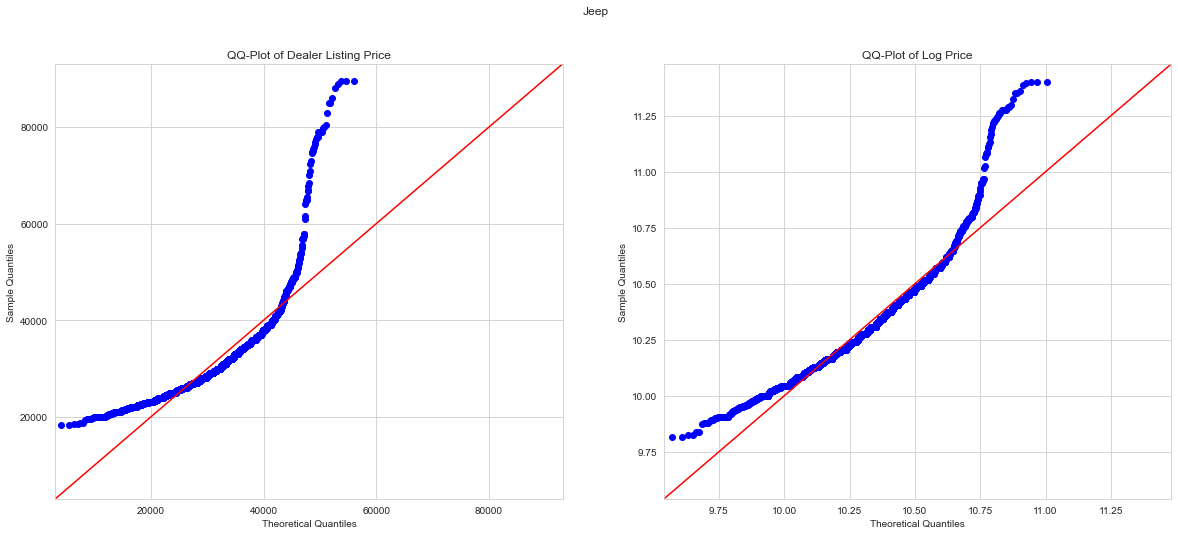

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sm.qqplot(Jeep['dealer_listing_price'],
           loc=Jeep['dealer_listing_price'].mean(),
           scale=Jeep['dealer_listing_price'].std(),
           ax=axes[0], line='45')
axes[0].set_title('QQ-Plot of Dealer Listing Price')

temp=np.log(Jeep['dealer_listing_price'])
sm.qqplot(temp,
         loc=temp.mean(),
         scale=temp.std(),
         ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Jeep')

### Transform number into Z Score, then divides by Standard Deviation...attempting to standardize the data


In [42]:
def quick_scale(series):
    return series.sub(np.mean(series)).div(np.std(series))

Text(0.5, 1.0, 'Distribution of Scaled Log-Prices')

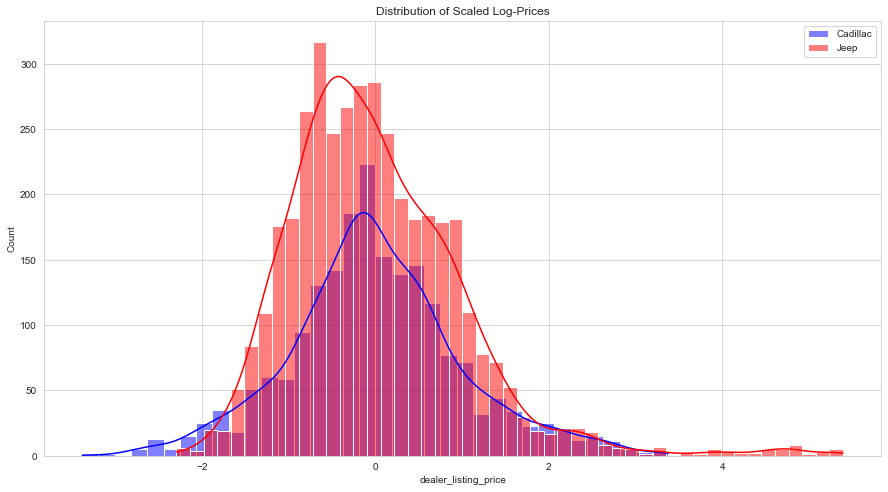

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(quick_scale(np.log(Cadillac['dealer_listing_price'])), kde=True, color='blue',ax=ax, label='Cadillac')
sns.histplot(quick_scale(np.log(Jeep['dealer_listing_price'])), kde=True, color='red',ax=ax, label='Jeep')
ax.legend()
ax.set_title('Distribution of Scaled Log-Prices')

Text(0.5, 0.98, 'Jeep')

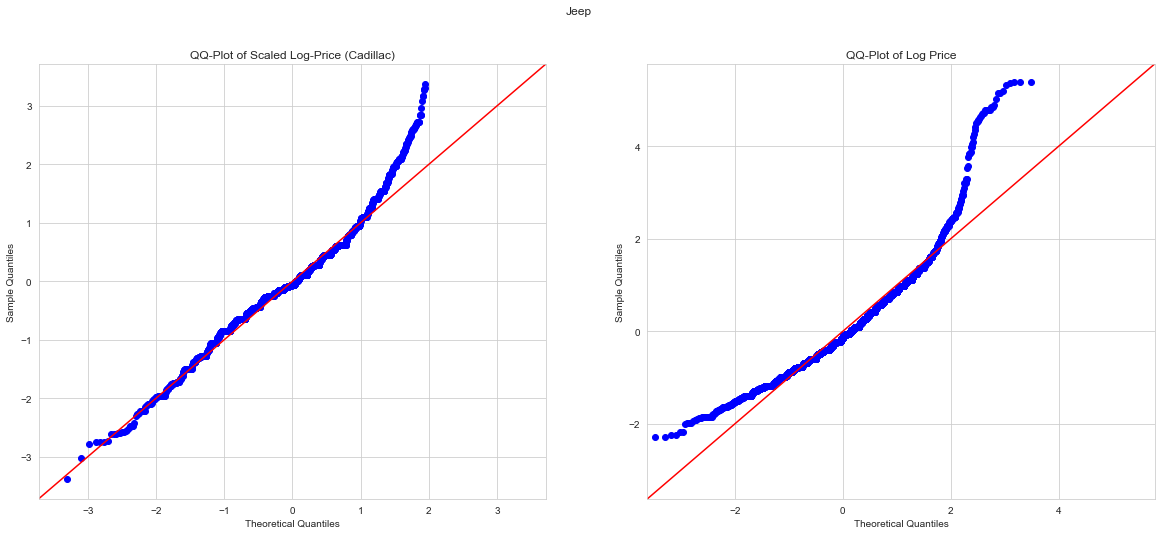

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
temp = quick_scale(np.log(Cadillac['dealer_listing_price']))
sm.qqplot(temp, line='45',ax=axes[0])
axes[0].set_title('QQ-Plot of Scaled Log-Price (Cadillac)')

temp=quick_scale(np.log(Jeep['dealer_listing_price']))
sm.qqplot(temp,ax=axes[1], line='45')
axes[1].set_title('QQ-Plot of Log Price')
fig.suptitle('Jeep')

In [45]:
Cadillac.loc[:, 'log_price'] = np.log(Cadillac.loc[:, 'dealer_listing_price'])
Jeep.loc[:, 'log_price']=np.log(Jeep.loc[:, 'dealer_listing_price'])

In [46]:
whole_data = pd.concat([Jeep,Cadillac])
whole_data.dropna(inplace=True)
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4965 entries, 4777 to 8617378
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sellercity            4965 non-null   object 
 1   sellerispriv          4965 non-null   bool   
 2   sellerlistsrc         4965 non-null   object 
 3   sellername            4965 non-null   object 
 4   sellerrating          4965 non-null   float64
 5   sellerrevcnt          4965 non-null   int64  
 6   sellerstate           4965 non-null   object 
 7   sellerzip             4965 non-null   float64
 8   vehbodystyle          4965 non-null   object 
 9   vehcertified          4965 non-null   bool   
 10  vehcolorext           4965 non-null   object 
 11  vehcolorint           4965 non-null   object 
 12  vehdrivetrain         4965 non-null   object 
 13  vehengine             4965 non-null   object 
 14  vehfeats              4965 non-null   object 
 15  vehfuel        

In [47]:
test_index = np.random.choice(whole_data.index,
                             size=whole_data.index.size // 5,
                             replace=False)
train_index = whole_data.index[[i not in test_index for i in whole_data.index]]
whole_data, test_data = whole_data.loc[train_index,:].copy(), whole_data.loc[test_index,:].copy()

In [48]:
categorical_features = []
numeric_features = []
drop_features=[]
data_cols=whole_data.columns[:26]
data_cols

Index(['sellercity', 'sellerispriv', 'sellerlistsrc', 'sellername',
       'sellerrating', 'sellerrevcnt', 'sellerstate', 'sellerzip',
       'vehbodystyle', 'vehcertified', 'vehcolorext', 'vehcolorint',
       'vehdrivetrain', 'vehengine', 'vehfeats', 'vehfuel', 'vehhistory',
       'vehlistdays', 'vehmake', 'vehmileage', 'vehmodel', 'vehpricelabel',
       'vehsellernotes', 'vehtype', 'vehtransmission', 'vehyear'],
      dtype='object')

In [49]:
i = 0
temp = whole_data[data_cols[i]].copy()
temp.head()

ListingID
4777       Waukesha
6242     Wentzville
12013        Ottawa
12334      Elmhurst
13173    Louisville
Name: sellercity, dtype: object

In [50]:
(temp.value_counts() / temp.size).head(10)

Chicago            0.021903
Battle Creek       0.021652
Columbus           0.010826
Louisville         0.010070
Atlanta            0.007805
White Bear Lake    0.007301
Palmyra            0.007301
Dallas             0.007049
Richmond           0.007049
Raleigh            0.007049
Name: sellercity, dtype: float64

In [51]:
# delete the city column, too many categories to add value to our analysis.
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head(), temp.value_counts()

In [ ]:
# too imbalanced to be worth keeping
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts() / temp.size

In [ ]:
temp = bin_sellerlistsrc(temp)
temp.value_counts() / temp.size

In [ ]:
# save this in the list of categorical features
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts() / temp.size

In [ ]:
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(temp, kde=True, ax=ax);

In [ ]:
#bin this one by rounding, but also keep the original as numeric
categorical_features.append(data_cols[i] + '_round')
numeric_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
sns.histplot(temp, kde=True, ax=axes[0])
axes[1].set_title('Original Distribution')

sns.histplot(np.log(temp), kde=True, ax=axes[1])
axes[1].set_title('Log Distribution');

In [ ]:
# do a log transform and keep numeric
numeric_features.append(data_cols[i]+ '_log')
i+= 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts().head(5).append(temp.value_counts().tail(5))

In [ ]:
# keep all of these, we will one-hot encode them and then select features later
categorical_features.append(data_cols[i])
i+= 1

In [ ]:
temp=whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.unique().size

In [ ]:
# drop this feature.  Too complex to work with.
#If I could bring in new data, I would like to chaneg these to coordinates,
# then see if we could use the numeric coordinates data to find centers where prices/packages differ
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#All of these are SUVs...Drop this column
drop_features.append(data_cols[i])
i += 1

In [ ]:
temp=whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
#keep as categorical
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp=whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp=bin_vehcolorext(temp)
temp.value_counts()

In [ ]:
#Categorical Feature!
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp.value_counts()

In [ ]:
temp = bin_vehcolorint(temp)
temp.value_counts()

In [ ]:
#bin this one, then keep as categorical variable
categorical_features.append(data_cols[i])
i += 1

In [ ]:
temp = whole_data[data_cols[i]].copy()
temp.head()

In [ ]:
temp = bin_vehdrivetrain(temp)
temp.value_counts()